In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


## Do share your feedback

## Idea is to:-
1. EDA
2. Apply Preprocessing as required (scaling, transformation etc..)
3. Fit ML algorithms. Will try to find right cluster size.Start with Kmeans and apply others
4. Visualize the clusters

In [2]:
#sklearn imports
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA  #Principal Component Analysis
from sklearn.manifold import TSNE      #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans    
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler 
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', 31)


#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_org = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")
df_org.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,5,13,6,6,-0.469819,0.358126,1.068105,-0.559650,-0.366905,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,4,6,16,9,0.591035,-0.396915,0.145834,-0.030798,0.471167,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,8,9,3,11,-0.679875,0.469326,0.349843,-0.288042,0.291470,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,8,9,6,4,-0.389456,0.626762,-1.074543,-1.521753,-1.150806,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,3,1,13,11,-0.120743,-0.615578,-1.064359,0.444142,0.428327,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      98000 non-null  int64  
 1   f_00    98000 non-null  float64
 2   f_01    98000 non-null  float64
 3   f_02    98000 non-null  float64
 4   f_03    98000 non-null  float64
 5   f_04    98000 non-null  float64
 6   f_05    98000 non-null  float64
 7   f_06    98000 non-null  float64
 8   f_07    98000 non-null  int64  
 9   f_08    98000 non-null  int64  
 10  f_09    98000 non-null  int64  
 11  f_10    98000 non-null  int64  
 12  f_11    98000 non-null  int64  
 13  f_12    98000 non-null  int64  
 14  f_13    98000 non-null  int64  
 15  f_14    98000 non-null  float64
 16  f_15    98000 non-null  float64
 17  f_16    98000 non-null  float64
 18  f_17    98000 non-null  float64
 19  f_18    98000 non-null  float64
 20  f_19    98000 non-null  float64
 21  f_20    98000 non-null  float64
 22

In [5]:
df_org.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000,98000.000000
mean,48999.500000,0.001220,0.005580,-0.001042,-0.000700,-0.003522,-0.001612,-0.003042,5.545918,6.763061,8.193163,8.057878,8.084990,7.076388,6.286102,0.003413,-0.002639,0.005404,0.001656,-0.005399,-0.004513,-0.000515,-0.001670,-0.038752,-0.220002,0.166434,-0.064309,-0.062540,0.098472,-0.230910
std,28290.307527,1.002801,1.000742,1.001373,1.000422,1.003061,1.000532,0.997434,3.691840,4.152348,5.904919,4.700226,4.197106,4.433308,4.120077,0.998940,1.001096,1.003277,1.001258,0.995965,1.004372,1.002962,0.999703,1.477858,1.494836,1.543014,1.576086,1.428055,1.305407,1.528476
min,0.000000,-4.732235,-4.202795,-4.377021,-4.010826,-4.535903,-4.300767,-4.894525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.377021,-4.535903,-4.182233,-4.468930,-4.149688,-4.894525,-4.732235,-4.438130,-6.873999,-8.234305,-7.792363,-6.593842,-7.375719,-7.335556,-6.954151
25%,24499.750000,-0.675226,-0.670985,-0.672779,-0.672540,-0.682510,-0.675066,-0.680421,3.000000,4.000000,4.000000,5.000000,5.000000,4.000000,3.000000,-0.671810,-0.677757,-0.671055,-0.672635,-0.680243,-0.678773,-0.679777,-0.675147,-1.022964,-1.203204,-0.903385,-1.128966,-0.975680,-0.746489,-1.262606
50%,48999.500000,0.002022,0.006650,-0.000324,-0.003185,-0.003307,0.001024,-0.002053,5.000000,6.000000,7.000000,7.000000,8.000000,6.000000,6.000000,0.003536,-0.004299,0.006535,0.001663,-0.001574,-0.000587,-0.000806,0.000819,-0.056687,-0.219046,0.167074,-0.099221,-0.070852,0.082230,-0.271319
75%,73499.250000,0.677271,0.677746,0.677086,0.672097,0.677589,0.673344,0.668112,8.000000,9.000000,11.000000,11.000000,11.000000,10.000000,9.000000,0.678679,0.673859,0.680903,0.673174,0.666996,0.672149,0.675437,0.676881,0.930158,0.764690,1.217432,0.987684,0.843212,0.925306,0.770516
max,97999.000000,4.490521,4.324974,4.560247,4.399373,4.050549,4.710316,3.998595,32.000000,30.000000,44.000000,36.000000,28.000000,38.000000,30.000000,4.490521,4.270708,4.157538,4.230849,4.710316,4.560247,4.399373,4.135419,6.517721,6.054831,7.527271,7.544731,7.005608,7.205971,6.977150


In [6]:
##correlation matrix
corr = df_org.corr()
corr.style.background_gradient(cmap='coolwarm')

#no correlations among features

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
id,1.000000,0.002856,-0.005167,0.001404,0.002268,-0.001201,-0.001297,0.001249,-0.003181,0.001774,-0.001422,-0.000181,0.003843,-0.001667,-0.002323,-0.004569,0.000797,0.002766,0.002510,0.001381,-0.001869,0.001981,-0.003020,0.001247,0.000065,0.001376,-0.003301,0.001145,0.004146,0.000309
f_00,0.002856,1.000000,-0.001955,0.002660,0.000105,0.008797,0.003817,0.002903,-0.003847,-0.000866,-0.000976,0.002510,-0.000938,0.004578,-0.001075,-0.003255,0.005267,-0.001998,0.005100,-0.000561,0.000437,0.002687,-0.000447,0.004087,-0.003756,0.001088,0.006216,0.000615,0.003888,0.001103
f_01,-0.005167,-0.001955,1.000000,0.001402,-0.001698,-0.001727,-0.001444,0.001826,0.006539,0.001023,0.003428,0.002071,-0.002024,-0.007009,-0.006544,-0.003968,-0.000157,0.000941,-0.000327,0.003146,-0.001402,-0.001852,0.001099,-0.002965,0.001760,-0.005635,0.000033,-0.001936,0.000229,-0.005528
f_02,0.001404,0.002660,0.001402,1.000000,-0.003271,-0.000732,-0.003743,0.003730,0.002603,0.004888,-0.004690,0.004708,0.001624,0.003369,-0.000620,0.002112,0.005397,-0.003674,-0.002383,0.006187,-0.002743,0.002398,-0.000301,0.004971,0.002971,-0.002328,0.001797,-0.001460,0.002210,0.000544
f_03,0.002268,0.000105,-0.001698,-0.003271,1.000000,0.000238,0.009835,0.002570,-0.000562,0.000095,0.001626,-0.001752,0.003533,-0.002081,-0.004417,0.004566,0.001454,-0.000372,0.003240,0.002039,0.000540,-0.005607,0.006154,0.001807,0.001241,-0.002235,0.000362,0.002074,0.000427,0.001842
f_04,-0.001201,0.008797,-0.001727,-0.000732,0.000238,1.000000,0.004550,0.004143,0.007164,-0.002044,0.002025,-0.003960,0.000218,0.001141,-0.000351,0.001196,-0.002549,-0.003036,-0.002535,0.000748,0.000731,0.000549,-0.000956,0.003801,-0.002564,-0.000324,-0.000765,0.002906,0.001421,-0.003389
f_05,-0.001297,0.003817,-0.001444,-0.003743,0.009835,0.004550,1.000000,0.004825,0.003289,-0.002826,-0.000695,0.002807,-0.001368,-0.000530,-0.001335,0.003204,-0.001235,0.003359,-0.002734,0.002783,0.007995,0.000832,-0.002269,0.002085,-0.003774,0.002300,0.002087,-0.001417,-0.003124,0.002519
f_06,0.001249,0.002903,0.001826,0.003730,0.002570,0.004143,0.004825,1.000000,-0.000300,-0.005988,0.009750,-0.004827,-0.004692,-0.001239,0.000689,-0.000707,0.004625,0.003590,0.004411,-0.006175,-0.005252,0.000395,-0.002691,0.000597,-0.002754,-0.002924,-0.006603,-0.000150,-0.005421,-0.000110
f_07,-0.003181,-0.003847,0.006539,0.002603,-0.000562,0.007164,0.003289,-0.000300,1.000000,-0.131742,0.036707,-0.106755,-0.012389,-0.196534,-0.117606,0.001908,0.000890,0.004975,-0.001435,-0.004443,0.003504,-0.002860,-0.000085,0.003461,-0.091825,0.030238,0.093444,-0.017622,-0.024546,-0.022357
f_08,0.001774,-0.000866,0.001023,0.004888,0.000095,-0.002044,-0.002826,-0.005988,-0.131742,1.000000,-0.360734,-0.051459,0.179527,-0.076524,-0.014362,0.000242,0.000011,-0.006046,-0.000272,-0.000551,0.002888,-0.001366,-0.000753,0.072612,0.028442,0.011038,0.072565,0.085690,-0.015953,-0.029955


In [7]:
#create training set
df_train = df_org.drop(['id'], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

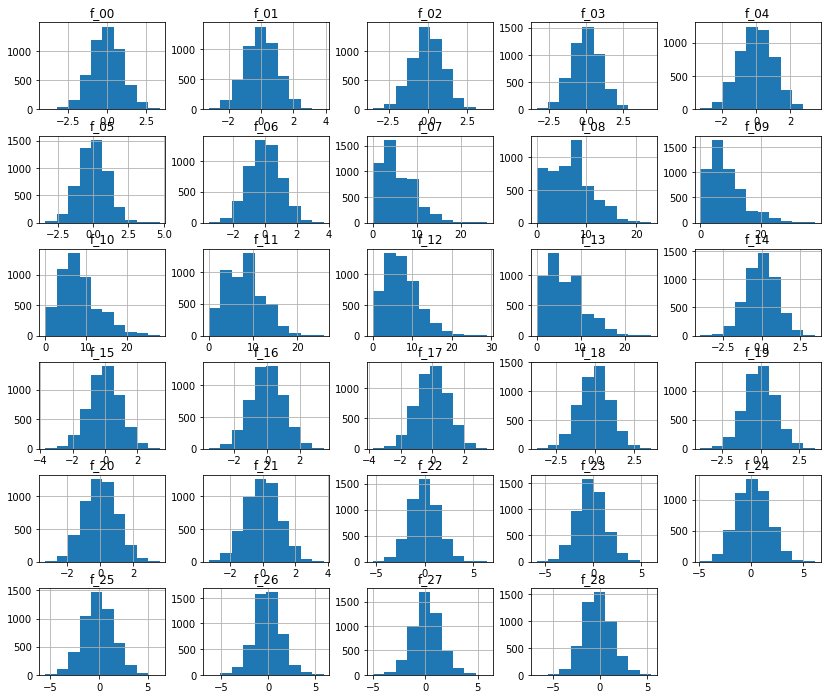

In [8]:
#plot histogram to visualize data distribution
df_train.sample(5000).hist(figsize=(14,12));
#f_07 to f_13 is not Gausian distribution. These are integar columns
# for float columns- mean is almost at 0, and Gausian distributed

## Preprocessing - standardize the data

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
train_scaled_np = StandardScaler().fit_transform(df_train)

In [11]:
#get a pandas df with same index and column
df_train_scaled = pd.DataFrame(train_scaled_np, columns=df_train.columns, index=df_train.index)

In [12]:
df_train_scaled.describe()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04
mean,-2.885674e-17,-3.103187e-17,-2.247635e-17,-3.842731e-18,1.638599e-17,1.812609e-17,1.885113e-18,-7.047424e-17,-3.364202e-17,4.741785e-17,1.393534e-16,-1.263388e-16,-4.132749e-17,-8.816530e-17,-1.319579e-17,5.365323e-18,-4.350262e-19,1.624098e-17,-1.711103e-17,1.711103e-17,-4.060244e-18,-1.363082e-17,6.235375e-18,-1.464588e-17,1.957618e-17,-6.815410e-18,-4.060244e-18,5.655340e-18,-1.348581e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-4.720258e+00,-4.205277e+00,-4.370001e+00,-4.008454e+00,-4.518572e+00,-4.296893e+00,-4.904094e+00,-1.502217e+00,-1.628740e+00,-1.387522e+00,-1.714368e+00,-1.926335e+00,-1.596195e+00,-1.525732e+00,-4.385106e+00,-4.528325e+00,-4.173980e+00,-4.464994e+00,-4.161099e+00,-4.868752e+00,-4.717770e+00,-4.437802e+00,-4.625127e+00,-5.361355e+00,-5.157982e+00,-4.142901e+00,-5.121103e+00,-5.694826e+00,-4.398679e+00
25%,-6.745596e-01,-6.760669e-01,-6.708199e-01,-6.715598e-01,-6.769189e-01,-6.730997e-01,-6.791260e-01,-6.896104e-01,-6.654248e-01,-7.101173e-01,-6.505843e-01,-7.350315e-01,-6.939295e-01,-7.975868e-01,-6.759433e-01,-6.743824e-01,-6.742529e-01,-6.734479e-01,-6.775810e-01,-6.713289e-01,-6.772592e-01,-6.736804e-01,-6.659755e-01,-6.577357e-01,-6.933338e-01,-6.755105e-01,-6.394323e-01,-6.472814e-01,-6.749869e-01
50%,8.003379e-04,1.070098e-03,7.166182e-04,-2.483485e-03,2.138090e-04,2.634614e-03,9.909725e-04,-1.478724e-01,-1.837671e-01,-2.020636e-01,-2.250707e-01,-2.024972e-02,-2.427968e-01,-6.944130e-02,1.225181e-04,-1.658266e-03,1.127149e-03,7.096954e-06,3.840797e-03,3.908499e-03,-2.894677e-04,2.489463e-03,-1.213596e-02,6.397907e-04,4.149117e-04,-2.215139e-02,-5.820545e-03,-1.244215e-02,-2.643729e-02
75%,6.741666e-01,6.716714e-01,6.772011e-01,6.725163e-01,6.790356e-01,6.746008e-01,6.728842e-01,6.647347e-01,5.387193e-01,4.753412e-01,6.259567e-01,6.945321e-01,6.594685e-01,6.587042e-01,6.759860e-01,6.757611e-01,6.732958e-01,6.706778e-01,6.751225e-01,6.737198e-01,6.739597e-01,6.787566e-01,6.556212e-01,6.587329e-01,6.811371e-01,6.674753e-01,6.342589e-01,6.333945e-01,6.551825e-01
max,4.476786e+00,4.316215e+00,4.555058e+00,4.398238e+00,4.041718e+00,4.709448e+00,4.011953e+00,7.165591e+00,5.596125e+00,6.063931e+00,5.944877e+00,4.744962e+00,6.975326e+00,5.755723e+00,4.491894e+00,4.268691e+00,4.138594e+00,4.223903e+00,4.734843e+00,4.544914e+00,4.386917e+00,4.138340e+00,4.436492e+00,4.197696e+00,4.770452e+00,4.827834e+00,4.949518e+00,5.444689e+00,4.715872e+00


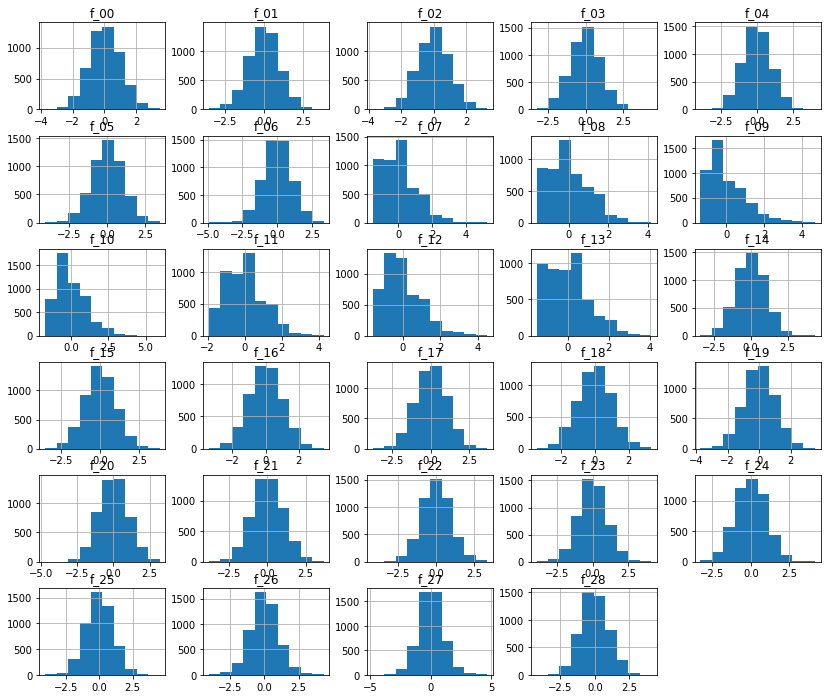

In [13]:
df_train_scaled.sample(5000).hist(figsize=(14,12));
#scaling has brought mean to zero for all columns
#float columns are distributed between -2.5 to 2.5

In [14]:
categorical_cols = ['f_07','f_08','f_09','f_10','f_11','f_12','f_13']

<AxesSubplot:>

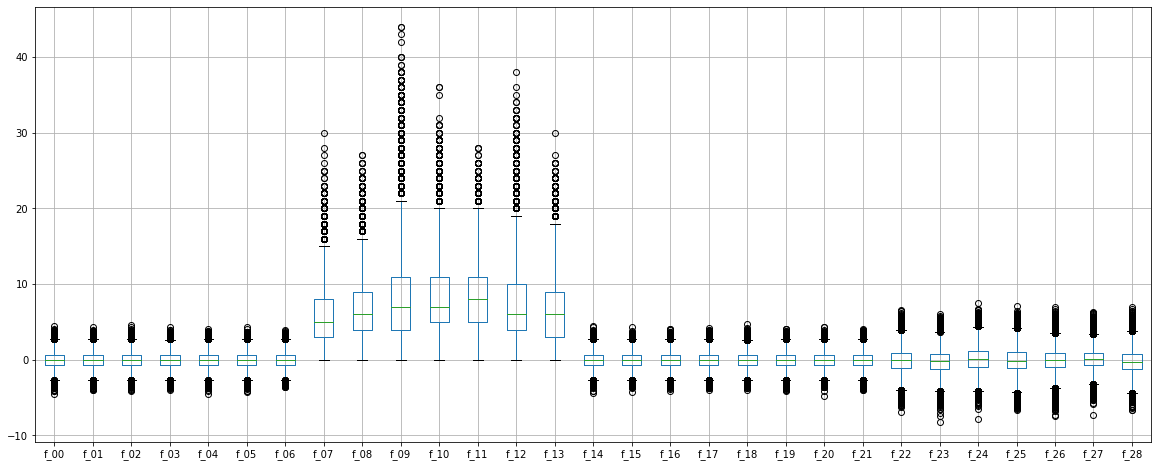

In [15]:
#understanding outliers
#df_train.sample(5000).boxplot(column = categorical_cols)
df_train.sample(50000).boxplot(figsize=(20,8))

In [16]:
#
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

In [17]:
df_train_scaled[categorical_cols] = pd.DataFrame(pt.fit_transform(df_train[categorical_cols]), columns = categorical_cols)

<AxesSubplot:>

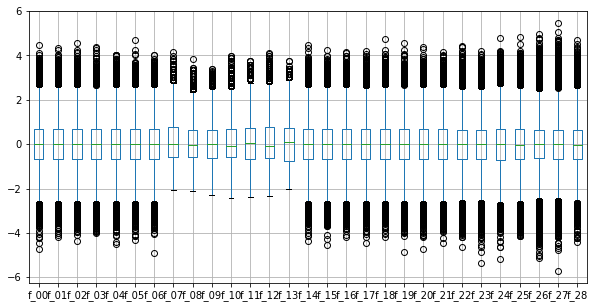

In [18]:
df_train_scaled.boxplot(figsize=(10,5))

# PCA
Get the sense of how many reduced dimensions can explain  whole data

In [19]:
%%time
#PCA with three principal components
pca_model = PCA(n_components=29)
df_pca = pca_model.fit_transform(df_train_scaled)

CPU times: user 287 ms, sys: 110 ms, total: 398 ms
Wall time: 154 ms


In [20]:
pca_model.explained_variance_ratio_, pca_model.explained_variance_ratio_.cumsum()
#none of the component is playing any major role

(array([0.06207611, 0.04947658, 0.04612902, 0.04009478, 0.03969473,
        0.03615165, 0.03519807, 0.03508012, 0.03503988, 0.0348631 ,
        0.03479614, 0.0346157 , 0.03454689, 0.0344966 , 0.03441105,
        0.03434412, 0.03426725, 0.03408588, 0.03397451, 0.03380036,
        0.03372842, 0.03288364, 0.03175667, 0.02895012, 0.02875708,
        0.02761806, 0.02478449, 0.02193003, 0.01244894]),
 array([0.06207611, 0.1115527 , 0.15768171, 0.1977765 , 0.23747123,
        0.27362287, 0.30882094, 0.34390106, 0.37894094, 0.41380405,
        0.44860019, 0.48321589, 0.51776278, 0.55225938, 0.58667043,
        0.62101455, 0.6552818 , 0.68936768, 0.72334219, 0.75714254,
        0.79087096, 0.8237546 , 0.85551127, 0.88446139, 0.91321847,
        0.94083654, 0.96562102, 0.98755106, 1.        ]))

##  k-mean clustering 

In [21]:
# model = KMeans(n_clusters=4, init="k-means++")
# # fit the model
# model.fit(df_train_scaled)
# #Add the cluster vector to our DataFrame, X
# # df_train_scaled["Cluster"] = model.labels_
# clusters = pd.unique(model.labels_)
# clusters

#### Will try with a range of clusters and will do some plotting to arrive at cluster size
start with small dataset and subsequently try with whole


In [22]:
%%time

K=range(2,12)
wss = []
silhoute_score = []
for k in K:
    print("k: ", k)
    kmeans= KMeans(n_clusters=k,init="k-means++", random_state=211)
    kmeans= kmeans.fit(df_train_scaled)
    labels = kmeans.labels_
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    sil_score = metrics.silhouette_score(df_train_scaled, labels, metric="euclidean", sample_size=30000)
    silhoute_score.append(sil_score)
    

k:  2
k:  3
k:  4
k:  5
k:  6
k:  7
k:  8
k:  9
k:  10
k:  11
CPU times: user 7min 25s, sys: 1min 28s, total: 8min 54s
Wall time: 3min 15s


In [23]:
#get the metrics into df
cluster_metrics = pd.DataFrame({'Clusters' : K, 'WSS' : wss, 'silhoute_score':silhoute_score})
cluster_metrics

,Clusters,WSS,silhoute_score
0,2,2.726455e+06,0.040409
1,3,2.654987e+06,0.035705
2,4,2.598807e+06,0.035471
3,5,2.556889e+06,0.034425
4,6,2.523618e+06,0.033462
5,7,2.499115e+06,0.032124
6,8,2.476905e+06,0.031446
7,9,2.457065e+06,0.031013
8,10,2.439132e+06,0.030378
9,11,2.423689e+06,0.030053


<AxesSubplot:xlabel='Clusters', ylabel='WSS'>

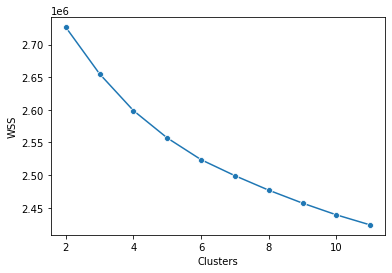

In [24]:
sns.lineplot(x = 'Clusters', y = 'WSS', data = cluster_metrics, marker="o")
#knee jerk point

<AxesSubplot:xlabel='Clusters', ylabel='silhoute_score'>

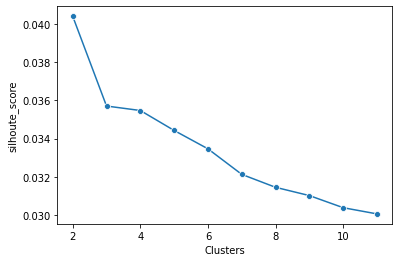

In [25]:
sns.lineplot(x = 'Clusters', y = 'silhoute_score', data = cluster_metrics, marker="o")
#higher better

#### ---> k-mean clustering do suggests 4 clusters

In [26]:
model = KMeans(n_clusters=4, init="k-means++")
# fit the model
model.fit(df_train_scaled)
#Add the cluster vector to our DataFrame, X
# df_train_scaled["Cluster"] = model.labels_
clusters = pd.unique(model.labels_)
clusters

array([0, 2, 1, 3], dtype=int32)

In [27]:
np.unique(model.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([29039, 16934, 27789, 24238]))

### submission

In [28]:
# submission = pd.DataFrame({'Id':df_org['id'].values,
#                            'Predicted':model.labels_})
# submission.to_csv("submission.csv", index = False)
# submission.info()

#### kmean score on public score is quite low, so trying other models
##### kmean score with 4 cluster. - 0.22381
##### Kmean score with 7 cluster - 0.26360

## GaussianMixture

#### trying both GaussianMixture , BayesianGaussianMixture

In [29]:
%%time

n_components_range=range(3,8)
bic_values = []
aic_values = []

for n_components in n_components_range:
    print("n_components: ", n_components)
    # define the model
    gm_model = GaussianMixture(n_components=n_components,
                                n_init=1,
                                init_params='kmeans',
                              random_state=None)
    # fit the model
    gm_model.fit(df_train_scaled)
    bic_values.append(gm_model.bic(df_train_scaled))
    aic_values.append(gm_model.bic(df_train_scaled))

bic_values, aic_values

n_components:  3
n_components:  4
n_components:  5
n_components:  6
n_components:  7
CPU times: user 2min 26s, sys: 1min 21s, total: 3min 48s
Wall time: 58.5 s


([7915635.133068041,
  7911984.087839107,
  7889310.824609202,
  7872535.708344006,
  7868228.928749583],
 [7915635.133068041,
  7911984.087839107,
  7889310.824609202,
  7872535.708344006,
  7868228.928749583])

<AxesSubplot:>

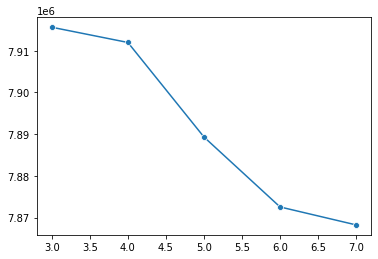

In [30]:
sns.lineplot(x = n_components_range, y = bic_values, marker="o")

<AxesSubplot:>

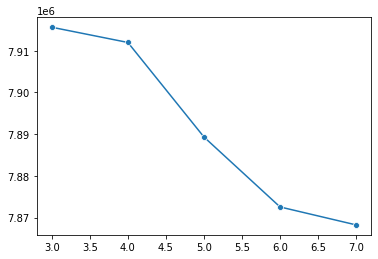

In [31]:
sns.lineplot(x = n_components_range, y = aic_values, marker="o")

In [32]:
%%time

n_components = 7
# define the model
gm_model = GaussianMixture(n_components=n_components)
# fit the model
gm_model.fit(df_train_scaled)
# assign a cluster to each example
yhat_gm = gm_model.predict(df_train_scaled)
# retrieve unique clusters
clusters = pd.unique(yhat_gm)



#gm_model.bic(df_train_scaled), gm_model.aic(df_train_scaled)

CPU times: user 51 s, sys: 28.4 s, total: 1min 19s
Wall time: 20.2 s


In [33]:
gm_model.bic(df_train_scaled), gm_model.aic(df_train_scaled)

(7871211.812353102, 7840322.4924997)

In [34]:
yhat_gm

array([2, 0, 3, ..., 3, 5, 0])

In [35]:
df_train_scaled.head(4)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389551,-0.917695,0.649105,0.589499,-0.824775,0.734849,2.267432,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.473738,0.360372,1.059236,-0.560604,-0.362972,-0.471839,-0.754257,-0.762195,-0.711585,0.911572,-0.680948,0.762783,0.960482,1.045296,0.683323
1,-0.688544,-0.459195,0.654321,0.995533,-1.644472,0.864967,-0.087835,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,0.588248,-0.393846,0.139972,-0.032414,0.478499,-0.422434,-0.089129,-1.783073,-0.541815,0.454693,1.032386,-0.133948,-0.552942,0.355435,-1.602671
2,0.805607,0.318753,-1.167963,-0.623531,0.108638,0.785146,1.996476,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,-0.684017,0.471450,0.343316,-0.289336,0.298074,-0.407243,-1.597140,1.193015,2.236943,0.088090,-1.513324,-0.577814,0.979171,-0.926250,-2.224327
3,-0.500743,0.223305,0.264788,0.232124,0.417259,-1.219016,0.142257,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221,-0.393288,0.628715,-1.076425,-1.521504,-1.150052,0.621083,1.284518,0.534669,0.727667,-1.218753,0.825698,-1.164842,-0.397908,-0.114228,0.307002


### Submission

In [36]:
# submission = pd.DataFrame({'Id':df_org['id'].values,
#                            'Predicted':yhat_gm})
# submission.to_csv("submission.csv", index = False)
# submission.info()

In [37]:
# submission.head()

### public score - 0.52266
##### good improvement over kmeans clearly

### BayesianGaussianMixture

In [38]:
%%time

n_components = 7
# define the model
bgm_model = BayesianGaussianMixture(n_components=n_components)
# fit the model
bgm_model.fit(df_train_scaled)
# assign a cluster to each example
yhat_bgm = bgm_model.predict(df_train_scaled)
# retrieve unique clusters
clusters = pd.unique(yhat_bgm)

CPU times: user 2min 25s, sys: 1min 24s, total: 3min 49s
Wall time: 58.9 s


In [39]:
bgm_predict_proba = bgm_model.predict_proba(df_train_scaled)
bgm_predict_proba

array([[3.43299506e-03, 5.59663713e-07, 1.14301348e-02, ...,
        5.06117341e-03, 3.35242706e-04, 2.21853511e-03],
       [1.31912011e-05, 1.94978823e-02, 8.87930630e-01, ...,
        1.96604328e-02, 6.77864054e-03, 6.56419610e-02],
       [1.10601582e-01, 4.00734032e-09, 1.20437904e-04, ...,
        5.48362347e-05, 7.98927038e-04, 2.22344002e-05],
       ...,
       [9.60593133e-01, 1.04450020e-04, 5.93770481e-03, ...,
        1.00653704e-03, 2.88694626e-02, 2.14276394e-04],
       [1.36944065e-01, 4.65197955e-02, 7.26701728e-02, ...,
        7.05109960e-01, 4.59816564e-04, 3.77214189e-02],
       [1.97834137e-09, 6.08958093e-08, 2.84076260e-04, ...,
        3.82412559e-02, 6.32688669e-06, 8.70848478e-01]])

In [40]:
#max probability is corresponding to max probability amount 7 clusters
bgm_predict_proba_max = bgm_predict_proba.max(axis=1)

<AxesSubplot:>

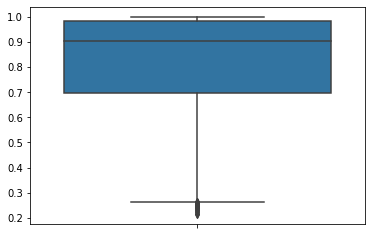

In [41]:
sns.boxplot(y=bgm_predict_proba_max)

In [42]:
sum(bgm_predict_proba_max < .5)/len(bgm_predict_proba_max)

0.07169387755102041

### Submission

In [43]:
submission = pd.DataFrame({'Id':df_org['id'].values,
                           'Predicted':yhat_bgm})
submission.to_csv("submission.csv", index = False)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         98000 non-null  int64
 1   Predicted  98000 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


### public score - 0.59899
##### good improvement over GMM clearly

## Choose GMM cluster if BGMM predict_proba is low ?

In [44]:
yhat_gm

array([2, 0, 3, ..., 3, 5, 0])

In [45]:
y_concat = pd.DataFrame({'yhat_gm':yhat_gm, 'yhat_bgm':yhat_bgm, 'bgm_predict_proba_max':bgm_predict_proba_max})
y_concat.head(4)

,yhat_gm,yhat_bgm,bgm_predict_proba_max
0,2,3,0.977521
1,0,2,0.887931
2,3,3,0.888402
3,4,1,0.866635


In [46]:
y_concat['bgm_predict_proba_max']<.5

0        False
1        False
2        False
3        False
4        False
         ...  
97995    False
97996     True
97997    False
97998    False
97999    False
Name: bgm_predict_proba_max, Length: 98000, dtype: bool

#### just selecting for all proba less than 60 percent, we will choose GMM

In [47]:
yhat_selected = []
threshold_proba = .5
for y_gm, y_bgm, bgm_proba in zip(yhat_gm, yhat_bgm, bgm_predict_proba_max):
    if bgm_proba < threshold_proba:
        yhat_selected.append(y_gm)
    else:
        yhat_selected.append(y_bgm)

In [48]:
len(yhat_selected), yhat_selected[:6]

(98000, [3, 2, 3, 1, 5, 2])

In [49]:
yhat_selected[97995:97997], y_concat[97995:97997]

([2, 0],
        yhat_gm  yhat_bgm  bgm_predict_proba_max
 97995        0         2               0.552135
 97996        0         6               0.489502)

### submission

In [50]:
# submission = pd.DataFrame({'Id':df_org['id'].values,
#                            'Predicted':yhat_selected})
# submission.to_csv("submission.csv", index = False)
# submission.info()

In [51]:
submission.tail(10)

,Id,Predicted
97990,97990,1
97991,97991,3
97992,97992,4
97993,97993,0
97994,97994,2
97995,97995,2
97996,97996,6
97997,97997,0
97998,97998,4
97999,97999,6


### public score - 0.55041
#### score has reduced, have to try different technique

# Visualizing cluster

PCA could be used to reduce the dimenstion to 1,2 & 3. And same could be plotted to visiualize. Provided PCA components are able to explain variance.
Which is not the case here. PCA explained_variance_ratio_ is low for first 3 PCs

Links refered:

https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters/notebook <br>
https://stats.stackexchange.com/questions/324843/visualization-problem-of-15-attributes-which-is-clustered-into-2-cluster

In [52]:
cluster_size = 7 
plot_x_df = df_train_scaled.copy()
plot_x_df['Cluster'] = yhat_bgm

In [53]:
plot_x_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,Cluster
0,-0.389551,-0.917695,0.649105,0.589499,-0.824775,0.734849,2.267432,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.473738,0.360372,1.059236,-0.560604,-0.362972,-0.471839,-0.754257,-0.762195,-0.711585,0.911572,-0.680948,0.762783,0.960482,1.045296,0.683323,3
1,-0.688544,-0.459195,0.654321,0.995533,-1.644472,0.864967,-0.087835,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,0.588248,-0.393846,0.139972,-0.032414,0.478499,-0.422434,-0.089129,-1.783073,-0.541815,0.454693,1.032386,-0.133948,-0.552942,0.355435,-1.602671,2
2,0.805607,0.318753,-1.167963,-0.623531,0.108638,0.785146,1.996476,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,-0.684017,0.471450,0.343316,-0.289336,0.298074,-0.407243,-1.597140,1.193015,2.236943,0.088090,-1.513324,-0.577814,0.979171,-0.926250,-2.224327,3
3,-0.500743,0.223305,0.264788,0.232124,0.417259,-1.219016,0.142257,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221,-0.393288,0.628715,-1.076425,-1.521504,-1.150052,0.621083,1.284518,0.534669,0.727667,-1.218753,0.825698,-1.164842,-0.397908,-0.114228,0.307002,1
4,-0.670613,-1.044343,-0.268745,-1.828801,-0.285713,-1.850223,0.786963,0.756900,0.187543,-0.394246,-1.135381,-1.954502,1.271662,1.118063,-0.124288,-0.612271,-1.066274,0.441932,0.435485,-1.617255,-0.433152,0.324273,0.218614,-1.484025,0.847369,-0.622034,1.166086,-0.385886,-1.149094,5


In [54]:
#plotX is a DataFrame containing 5000 values sampled randomly from X
plotX = pd.DataFrame(np.array(plot_x_df.sample(20000)))

#Rename plotX's columns since it was briefly converted to an np.array above
plotX.columns = plot_x_df.columns

In [55]:
#PCA with one principal component
pca_1d = PCA(n_components=1)

#PCA with two principal components
pca_2d = PCA(n_components=2)

#PCA with three principal components
pca_3d = PCA(n_components=3)

In [56]:
#This DataFrame holds that single principal component mentioned above
PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three principal components that will aid us
#in visualizing our clusters in 3-D
PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))

In [57]:
pca_1d.explained_variance_ratio_, pca_2d.explained_variance_ratio_, pca_3d.explained_variance_ratio_

(array([0.06262096]),
 array([0.0626215 , 0.04985455]),
 array([0.06254191, 0.0480651 , 0.04396578]))

In [58]:
PCs_1d.columns = ["PC1_1d"]

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [59]:
plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')
plotX["dummy"] = 0

In [60]:
#This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)

In [61]:
#Instructions for building the 1-D plot
data = []
for cluster in range(cluster_size):
    #trace is for 'Cluster x'
    trace = go.Scatter(
                        x = plotX[plotX["Cluster"] == cluster]["PC1_1d"],
                        y = plotX[plotX["Cluster"] == cluster]["dummy"],
                        mode = "markers",
                        name = f"Cluster {cluster}",
                        text = None)
    data.append(trace)

title = "Visualizing Clusters in One Dimension Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= '',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

# iplot(fig)

In [62]:
#Instructions for building the 2-D plot
data = []
for cluster in range(cluster_size):
    trace = go.Scatter(
                        x = plotX[plotX["Cluster"] == cluster]["PC1_2d"],     #PC1_2d
                        y = plotX[plotX["Cluster"] == cluster]["PC2_2d"],     #PC2_2d
                        mode = "markers",
                        name = f"Cluster {cluster}",
                        text = None)
    data.append(trace)



title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

# iplot(fig)

In [63]:
#Instructions for building the 3-D plot
data = []
for cluster in range(cluster_size): 
    #trace is for 'Cluster 0'
    trace = go.Scatter3d(
                        x = plotX[plotX["Cluster"] == cluster]["PC1_3d"],
                        y = plotX[plotX["Cluster"] == cluster]["PC2_3d"],
                        z = plotX[plotX["Cluster"] == cluster]["PC3_3d"],
                        mode = "markers",
                        name = f"Cluster {cluster}",
                        text = None)
    data.append(trace)


title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

# iplot(fig)